In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from standard_incomplete_markets import (example_calibration, backward_iteration,
                                         get_lottery, forward_iteration, steady_state, 
                                         policy_impulse_response, impulse_response)

In [2]:
ss = steady_state(**example_calibration())

Note: this code does not work for shocks to the Markov transition matrix `Pi` or the grid `a_grid`.

# Step 1a: iterate backward from a shock at $T-1$ to get the impact on policy
All that matters for the policy function is the distance to a shock—so we can get the impact of a policy at every distance up through $T-1$ by doing a single backward iteration starting from $T-1$.

We'll implement this using our already-existing `policy_impulse_response` function, by feeding in the path for the shocked variable that has its steady-state value everywhere except $T-1$. At $T-1$, we'll multiply the shock by some small $h$, and add it to the steady state.

For scalar household inputs like `r`, it's natural to look at the effect of a unit shock. But some vector household inputs like `y`, there's no clear "unit" shock, which is why we need to allow for general vector shocks. (Formally, we're going to end up taking the "directional" or "Gateaux" derivative with respect to these shocks.)

In [3]:
def terminal_shock_results(ss, T, i, shock=1, h=1E-4):
    """Get first-order individual policy response to perturbation
    'shock' to 'i' at all horizons 0, ... , T-1"""
    
    # make sure steady-state value is array, add leading dimension
    ss_val = np.array(ss[i])[np.newaxis, ...]
        
    # make path with ss repeated on leading dimension for T periods
    shocked_path = np.repeat(ss_val, T, axis=0)
        
    # now add h times shock to input at T-1
    shocked_path[T-1] += h * shock
    
    # now use this shocked path as input, get a and c
    _, a, c = policy_impulse_response(ss, T, **{i: shocked_path})
    
    # right now, a[T-1] is 0 periods to shock, and a[0] is T-1 periods, etc.
    # switch order so that a[0] is 0 periods to shock, etc.
    return a[::-1], c[::-1]

# Step 1b: compute one-period-ahead distributions from shocked asset policies
Now that we have a $T\times n_s \times n_a$ array `a` giving the effect of the shock on the asset policy on the grid at each horizon, we want to find the effect of this changed asset policy on the one-period-ahead distribution.

This is simple: we'll just use the forward iteration, starting from the steady-state distribution, in each period.

In [4]:
def one_period_ahead(ss, a):
    """If a[t] is (shocked) asset policy at time t, find distribution
    D[t+1], assuming D[t] is the steady-state distribution"""
    
    D = np.empty_like(a)
    for t in range(D.shape[0]):
        a_i, a_pi = get_lottery(a[t], ss['a_grid'])
        D[t] = forward_iteration(ss['D'], ss['Pi'], a_i, a_pi)
    return D

# Step 1c: getting $\mathcal{Y}_u^{o,i}$ and $\mathcal{D}_u^i$
Following the sequence-space Jacobian paper, we now need to consolidate the information we have into two sets of numbers:

- First, for each shock $i$, and each policy $o\in \{A, C\}$, we want to calculate the change in policy when the shock is $u$ periods in the future, aggregated over the original steady-state distribution. This is $\mathcal{Y}_u^{o,i}$.


- Next, for each shock $i$, we want to calculate the change in the next period's distribution caused by the change in policy today when the shock is $u$ periods in the future. This is $\mathcal{D}_u^i$.


We have the ingredients for these, but we've only computed the effect from the shock multiplied by $h$. To turn this into a numerical derivative—the actual first order effect of the shock—we need to subtract the steady state and then divide by $h$.

This brings up an important, subtle point: since we never solved for the *exact* steady state, but only iterated backward up to some numerical tolerance, there will be some changes in policy as we iterate backward in `terminal_shock_results` even in the absence of any shock. When we divide by small $h$, these will become larger. To eliminate this source of numerical error, one simple approach is to run `terminal_shock_results` without any shocks (a "ghost run"), and subtract all our results by this.

This doubles the cost if we're only interested in one shock, but if we are interested in multiple shocks, the cost is spread across them.

The function below will take in an entire dictionary of shocks. Normally, the key in the dictionary will be just the input that we're shocking. But for vector inputs like incomes `y`, we might want to shock them in different ways, in which case `y` alone isn't a good name, so the user will have the option of supplying a tuple `(k,i)`, where `k` is the input that's shocked, and `i` is a unique name for the shock.

In [5]:
def get_curlyYs_curlyDs(ss, T, shocks, h=1E-4):
    """For each shock 'i' in shocks, find curlyY[o][i] and curlyD[i]
    at all horizons up to T"""
    
    # start with "ghost run": what happens without any shocks?
    a_noshock, c_noshock = terminal_shock_results(ss, T, 'r', 0, h)
    D_noshock = one_period_ahead(ss, a_noshock)
    
    # initialize dicts of curlyYs[o][i] and curlyDs[i]
    curlyYs = {'A': {}, 'C': {}}
    curlyDs = {}
    
    # iterate through shocks
    for ii, shock in shocks.items():
        # if tuple, split into name of input k and identifier i of shock
        if isinstance(ii, tuple):
            k, i = ii
        else:
            k, i = ii, ii
        
        a, c = terminal_shock_results(ss, T, k, shock, h)
        D = one_period_ahead(ss, a)
        
        # aggregate using steady-state distribution to get curlyYs
        curlyYs['A'][i] = np.sum(ss['D']*(a - a_noshock), axis=(1,2)) / h
        curlyYs['C'][i] = np.sum(ss['D']*(c - c_noshock), axis=(1,2)) / h
        
        curlyDs[i] = (D - D_noshock) / h
    
    return curlyYs, curlyDs

# Step 2: obtain $\mathcal{E}_u^o$, the expected value of each policy $o$ at horizon $u$
The next step in the sequence-space Jacobian paper is to obtain $\mathcal{E}_u^o$ for each policy $o\in {A,C}$, which gives the *expected* value of $o$, $u$ periods from now, at each point in today's grid, assuming that *steady-state policies are followed*. For instance, $\mathcal{E}_3^C$ is an $n_s\times n_a$ array telling us "how much do households at each gridpoint today expect to consume in three periods?"

The law of iterated expectations means that these are easy to calculate recursively: if we take the expectation today of what $\mathcal{E}_{u}^o$ will be tomorrow, we get $\mathcal{E}_{u+1}^o$.

As a quick refresher from `standard_incomplete_markets`, the process of going from the state $(s,a)$ today to the state $(s',a')$ tomorrow has two steps:

- First, the household chooses a policy $a'(s,a)$, which we discretize into a "lottery" where there is $\pi(s,a)$ chance we go to asset gridpoint $i(s,a)$, and $1-\pi(s,a)$ chance we go to asset gridpoint $i(s,a)+1$.


- Second, the exogenous state $s$ is updated to $s'$, following probabilities in the Markov transition matrix $\Pi$.

To take expectations conditional on today's state $(s,a)$ for something that we know the value of at each state tomorrow $(s',a')$, we need to perform these steps backward: first, take expectations over $s'$, conditional on $s$, using the Markov matrix $\Pi$; and second, take expectations over $a'$, conditional on $a$, using the policy lottery.

This is implemented in the function below, which takes in an $n_s\times n_a$ array `X` of values tomorrow, and returns an $n_s \times n_a$ array `expX` of their expected values today.

In [6]:
@numba.njit
def expectations_iteration(X, Pi, a_i, a_pi):
    """If X is n_s*n_a array of values at each gridpoint tomorrow,
    what is the expected value at each gridpoint today?"""
    
    # first, take expectations over all s' using Markov matrix Pi
    X = Pi @ X
    
    # next, take expectations over a' using policy lottery
    expX = np.empty_like(X)
    for s in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # expected value today of policy lottery reflects:
            # pi(s,a) chance we go to gridpoint i(s,a)
            # 1-pi(s,a) chance we go to gridpoint i(s,a)+1
            expX[s, a] = (a_pi[s, a] * X[s, a_i[s, a]]
                          + (1 - a_pi[s, a]) * X[s, a_i[s, a]+1])
            
    return expX

Now, we'll do a backward iteration to get all $\mathcal{E}_u^o$ for $u\in \{A, C\}$, by recursively taking expectations, noting that $\mathcal{E}_0^o$ is simply that actual value of $o$ at each point today.

In [7]:
def get_curlyEs(ss, T):
    """For outputs o = A and C, find expected value curlyE^o_u
    of o, u periods in the future, at each gridpoint today"""
    
    # initialize T*n_s*n_a arrays for curlyE^A and curlyE^C
    curlyEs = {'A': np.empty((T,) + ss['a'].shape),
               'C': np.empty((T,) + ss['c'].shape)}
    
    # at u=0, it's just the steady state policy
    curlyEs['A'][0] = ss['a']
    curlyEs['C'][0] = ss['c']
    
    # get steady-state policy lottery
    a_i, a_pi = get_lottery(ss['a'], ss['a_grid'])
    
    # recursively take expectations to get curlyE_u for u=1,...,T-1
    for o in ('A', 'C'):
        for u in range(1, T):
            curlyEs[o][u] = expectations_iteration(curlyEs[o][u-1],
                                                   ss['Pi'], a_i, a_pi)
            
    return curlyEs

# Step 3: form "fake news" matrix $\mathcal{F}^{o,i}$ for each $o,i$
The sequence-space Jacobian paper specifies the "fake news" matrix as the following:


$$
\mathcal{F}=\left[\begin{array}{ccccc}
\mathcal{Y}_{0} & \mathcal{Y}_{1} & \mathcal{Y}_{2} & \cdots & \mathcal{Y}_{T-1}\\
\mathcal{\mathcal{E}}_{0}'\mathcal{D}_{0} & \mathcal{\mathcal{E}}_{0}'\mathcal{D}_{1} & \mathcal{\mathcal{E}}_{0}'\mathcal{D}_{2} &  & \mathcal{\mathcal{E}}_{0}'\mathcal{D}_{T-1}\\
\mathcal{\mathcal{E}}_{1}'\mathcal{D}_{0} & \mathcal{\mathcal{E}}_{1}'\mathcal{D}_{1} & \mathcal{\mathcal{E}}_{1}'\mathcal{D}_{2} &  & \mathcal{\mathcal{E}}_{1}'\mathcal{D}_{T-1}\\
\vdots & \vdots & \vdots &  & \vdots\\
\mathcal{E}_{T-2}'\mathcal{D}_{0} & \mathcal{\mathcal{E}}_{T-2}'\mathcal{D}_{1} & \mathcal{\mathcal{E}}_{T-2}'\mathcal{D}_{2} & \cdots & \mathcal{\mathcal{E}}_{T-2}'\mathcal{D}_{T-1}
\end{array}\right] \tag{1}
$$

(This notation assumes that each $\mathcal{Y},\mathcal{D},\mathcal{E}$ has been flattened into a one-dimensional vector, i.e. a vector of length $n_s\cdot n_a$ rather than an array with dimensions $n_s \times n_a$. It also drops superscripts for convenience.)

An entry $\mathcal{F}_{t,s}^{o,i}$ of the fake news matrix, where $s>0$, tells us the aggregate response of $o$ at date $t$ if, at date 0, households "learn" that there is going to be a shock $i$ at date $s$, and then at date 1 learn that this shock isn't actually going to happen—that it was "fake news". (If $s=0$, then the shock actually happens at date 0.)

From (1) we see that $\mathcal{F}^{o, i}_{0, s} = \mathcal{Y}^{o,i}_s$. We recall that $\mathcal{Y}_s^{o,i}$ is the change in $o$, aggregated using the steady-state distribution, when shock $i$ is $s$ periods in the future. That's exactly what happens at date $t=0$: the incoming distribution hasn't changed yet, but households react to news about the future.


We also see that for $t>0$, $\mathcal{F}^{o, i}_{t, s} = (\mathcal{E}^o_{t-1})'\mathcal{D}^i_{s}$. Intuitively, since the news shock at 0 was fake, the *only* reason why aggregate $o$ differs at date $t>0$ is that households reacted to the news at date 0, which has persistent effects via the distribution of states. The effect of their reaction to news of the date-$s$ shock on the date-1 distribution is $\mathcal{D}^i_{s}$, and to get the impact of this distributional change on the date-$t$ aggregate of $o$, we take a dot product with $\mathcal{E}^o_{t-1}$.

We implement (2) as follows. This function takes in $\mathcal{Y}^{o,i}$ as `curlyY`, $\mathcal{D}^i$ as `curlyD`, and $\mathcal{E}^o$ as `curlyE`, for any particular $o,i$.

In [8]:
@numba.njit
def fake_news(curlyY, curlyD, curlyE):
    T = len(curlyY)
    F = np.empty((T, T))

    # F[0, s] = curlyY(0, s)
    F[0, :] = curlyY

    # F[t, s] = dot product of curlyE(t-1) and curlyD(s) for t>0
    # (Numba only does vdot on 1-dim arrays, use ravel() to flatten to 1-dim)
    for t in range(1, T):
        for s in range(T):
            F[t, s] = np.vdot(curlyE[t-1].ravel(), curlyD[s].ravel())

    return F

# Step 4: convert from fake news to Jacobians
The transformation from a fake news matrix $\mathcal{F}$ to the Jacobian $\mathcal{J}$ is very simple, following the recursion

$$
\mathcal{J}_{t,s}=
\begin{cases}
\mathcal{J}_{t-1,s-1}+\mathcal{F}_{t,s} & t,s\geq 1 \\
\mathcal{F}_{t,s} & t=0 \text{ or } s=0
\end{cases} \tag{2}
$$

The intuition behind the recursion (2) is that to first order, the only difference between the time-$t$ response to a time-$s$ shock, and the time-$t-1$ response to a time-$s-1$ shock, is that in the former case, we had an extra period of anticipating the shock. The effect of this extra period of anticipation at time $t$ is precisely the effect of the corresponding fake news shock. 

Implementing (2) is extremely simple:

In [9]:
def J_from_F(F):
    J = F.copy()
    for t in range(1, F.shape[0]):
        J[1:, t] += J[:-1, t-1]
    return J

# Putting it all together
We now have four functions, corresponding to the four steps of the fake news algorithm:

1. `get_curlyYs_curlyDs` obtains the $\mathcal{Y}^{o,i}$ and $\mathcal{D}^i$ for some set of shocks $i$ and $o\in\{A,C\}$.


2. `get_curlyEs` obtains the $\mathcal{E}^o$ for $o\in \{A,C\}$.


3. `fake_news` takes in any $\mathcal{Y}^{o,i}$, $\mathcal{D}^i$, and $\mathcal{E}^o$ and returns the fake news matrix $\mathcal{F}^{o,i}$.


4. `J_from_F` takes in any $\mathcal{F}^{o,i}$ and returns the Jacobian $\mathcal{J}^{o,i}$.


We now can combine these into a single function that, for a given steady state and set of shocks $i$, produces all Jacobians.

In [10]:
def jacobians(ss, T, shocks):
    curlyYs, curlyDs = get_curlyYs_curlyDs(ss, T, shocks)
    curlyEs = get_curlyEs(ss, T)
    
    Js = {'A': {}, 'C': {}}
    for o in Js:
        for i in curlyDs:
            F = fake_news(curlyYs[o][i], curlyDs[i], curlyEs[o])
            Js[o][i] = J_from_F(F)
            
    return Js

# Applying to an example and verifying

In [14]:
T = 300
Js = jacobians(ss, T, {'r': 1,
                       ('y', 'y_prop'): ss['y'],
                       ('y', 'y_equal'): 1})

Let's check out the fit for `r` first:

In [33]:
h = 0.001
times = [0, 10, 20]
paths = np.empty((T, len(times)))
for i_s, s in enumerate(times):
    paths[:, i_s] = impulse_response(ss, r = ss['r'] + h*(np.arange(T)==s))['C'] - ss['C']

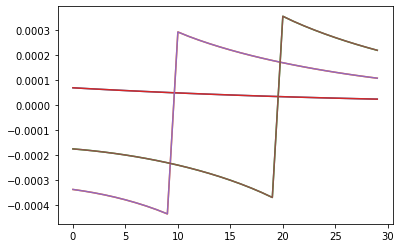

In [34]:
plt.plot(h*Js['C']['r'][:30, times])
plt.plot(paths[:30]);

Beautiful!!!!!

What about a proportional shock to `y`?

In [35]:
for i_s, s in enumerate(times):
    paths[:, i_s] = impulse_response(ss,
                        y = (1+ h*(np.arange(T)==s))[:, np.newaxis]*ss['y'])['C'] - ss['C']

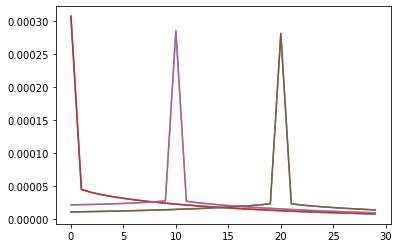

In [36]:
plt.plot(h*Js['C']['y_prop'][:30, times])
plt.plot(paths[:30]);

What about a lump-sum, equal shock to `y`?

In [37]:
for i_s, s in enumerate(times):
    paths[:, i_s] = impulse_response(ss,
                        y = h*(np.arange(T)==s)[:, np.newaxis] + ss['y'])['C'] - ss['C']

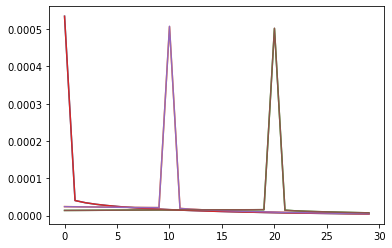

In [38]:
plt.plot(h*Js['C']['y_equal'][:30, times])
plt.plot(paths[:30]);